In [1]:
import os
import sys

sys.path.append("..")

from itertools import product
from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
)
from xai_ranking.metrics import (
    explanation_sensitivity, outcome_sensitivity,
    bootstrapped_explanation_consistency, cross_method_explanation_consistency,
    cross_method_outcome_consistency
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlresearch.utils import check_random_states, set_matplotlib_style
from sharp.utils import scores_to_ordering

RNG_SEED = 42

In [2]:
# Set up ranker for the moving company dataset:
X, ranks, score = preprocess_movers_data(fetch_movers_data(test=False))
qids_train = X.index.value_counts().to_numpy()

model = LGBMRanker(
    objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
)
model.fit(
    X=X,
    y=ranks,
    group=qids_train,
)

LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank', verbose=-1)

In [3]:
datasets = [
    {
        "name": "ATP",
        "data": preprocess_atp_data(fetch_atp_data()),
        "scorer": atp_score,
    },
    {
        "name": "CSRank",
        "data": preprocess_csrank_data(fetch_csrank_data()),
        "scorer": csrank_score,
    },
    {
        "name": "Higher Education",
        "data": preprocess_higher_education_data(
            fetch_higher_education_data(year=2020)
        ),
        "scorer": higher_education_score,
    },
    {
        "name": "Moving Company",
        "data": preprocess_movers_data(fetch_movers_data(test=True)),
        "scorer": model.predict,
    },
]
xai_methods = [
    {
        "iterations": 1,
        "name": "LIME",
        "experiment": lime_experiment,
        "kwargs": {"mode": "regression"}  # classification, regression
    },
    {
        "iterations": 5,
        "name": "BATCH_LIME",
        "experiment": lime_batch_experiment,
        "kwargs": {"mode": "regression"}  # classification, regression
    },
    {
        "iterations": 1,
        "name": "SHAP",
        "experiment": shap_experiment,
        "kwargs": {}
    },
    {
        "iterations": 5,
        "name": "BATCH_SHAP",
        "experiment": shap_batch_experiment,
        "kwargs": {}
    },
    {
        "iterations": 1,
        "name": "ShaRP",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            # "sample_size": 150,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": True
        }
    },
    {
        "iterations": 5,
        "name": "BATCH_ShaRP",
        "experiment": sharp_batch_experiment,
        "kwargs": {
            "verbose": True,
            # "sample_size": 150,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": True
        }
    },
    {
        "iterations": 1,
        "name": "HRE",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {
            "model_type": "OLS",  # DT, LR, OLS, PLS
            "s": 5
        }
    },
    {
        "iterations": 5,
        "name": "BATCH_HRE",
        "experiment": hierarchical_ranking_batch_explanation,
        "kwargs": {
            "model_type": "OLS",  # DT, LR, OLS, PLS
            "s": 5
        }
    },
    {
        "iterations": 1,
        "name": "HIL",
        "experiment": human_in_the_loop_experiment,
        "kwargs": {"upper_bound": 1, "lower_bound": None}
    },
    {
        "iterations": 5,
        "name": "BATCH_HIL",
        "experiment": human_in_the_loop_batch_experiment,
        "kwargs": {"upper_bound": 1, "lower_bound": None}
    },
    # {"iterations": 1, "name": "Participation", "experiment": participation_experiment},
]

total_states = sum(map(lambda x: x["iterations"], xai_methods)) * len(datasets)
random_states = (x for x in check_random_states(RNG_SEED, total_states))

In [4]:
# Uncomment to run full experiment

# results = {}
# for dataset in datasets:
#     results[dataset["name"]] = {}
#     for xai_method in xai_methods:
#         results[dataset["name"]][xai_method["name"]] = []
# 
#         experiment_func = xai_method["experiment"]
#         score_func = dataset["scorer"]
# 
#         X, ranks, scores = dataset["data"]
# 
#         for iteration_idx in range(xai_method["iterations"]):
#             random_state = next(random_states)
#             if "done" in dataset and dataset["done"]:
#                 continue
# 
#             kwargs = {} if "kwargs" not in xai_method else xai_method["kwargs"]
#             if dataset["name"] == "Moving Company" and xai_method["name"].endswith("ShaRP"):
#                 kwargs["sample_size"] = 150
# 
#             contributions = experiment_func(X, score_func, random_state=random_state, **kwargs)
# 
#             results[dataset["name"]][xai_method["name"]].append(contributions)
#             result_df = pd.DataFrame(contributions, columns=X.columns, index=X.index)
#             result_df.to_csv(
#                 f"results/_contributions_{dataset['name']}_{xai_method['name']}_{iteration_idx}.csv"
#             )

In [5]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/_contributions_"
                    f"{cur_dataset['name']}_{cur_xai_method['name']}_"
                    f"{iteration}.csv"
                )
                if os.path.isfile(fname):
                    (
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            pd.read_csv(fname, index_col=0)
                        )
                    )
    return return_dict

In [6]:
results = read_results_from_files()

In [7]:
results

{'ATP': {'LIME': [                         serve__pct_1st_serve  \
   player_name                                     
   John Isner                           5.728773   
   Nick Kyrgios                         5.980128   
   Reilly Opelka                        2.125014   
   Hubert Hurkacz                      -1.214858   
   Matteo Berrettini                    1.588932   
   ...                                       ...   
   Diego Schwartzman                    6.173668   
   Fabio Fognini                       -5.659780   
   Cristian Garin                      -1.388583   
   Bernabe Zapata Miralles              1.928366   
   Nikoloz Basilashvili                -5.861706   
   
                            serve__pct_1st_serve_points_won  \
   player_name                                                
   John Isner                                      8.373206   
   Nick Kyrgios                                    8.396664   
   Reilly Opelka                                   8.

# Explanation Sensitivity

In [8]:
help(explanation_sensitivity)

Help on function explanation_sensitivity in module xai_ranking.metrics._sensitivity:

explanation_sensitivity(original_data, contributions, rankings, n_neighbors=10, agg_type='mean', measure='kendall', **kwargs)



In [9]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

expl_sens_res = {}
expl_sens_sem = {}
for method in methods:
    expl_sens_res[method] = {}
    expl_sens_sem[method] = {}
    for dataset in datasets:
        rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
        result = explanation_sensitivity(
            dataset["data"][0], 
            results[dataset["name"]][method][0],
            rankings,
            measure="jaccard", n_features=2
        )
        expl_sens_res[method][dataset["name"]] = result[0]
        expl_sens_sem[method][dataset["name"]] = result[1]

In [10]:
pd.DataFrame(expl_sens_res)

,LIME,SHAP,ShaRP,HRE,HIL
ATP,0.344186,0.305426,0.344574,0.324031,0.385271
CSRank,0.695944,0.703527,0.556966,0.792945,0.292416
Higher Education,0.550537,0.520639,0.481794,0.578287,0.412050
Moving Company,0.855000,0.865600,0.860267,0.892100,0.994267


# Outcome Sensitivity

In [11]:
help(outcome_sensitivity)

Help on function outcome_sensitivity in module xai_ranking.metrics._sensitivity:

outcome_sensitivity(original_data, score_func, contributions, threshold=0.8, n_neighbors=10, n_tests=10, std_multiplier=0.2, aggregate_results=False, random_state=None)



In [12]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

out_sens_res = {}
out_sens_sem = {}
for method in methods:
    out_sens_res[method] = {}
    out_sens_sem[method] = {}
    for dataset in datasets:
        rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
        result = outcome_sensitivity(
            dataset["data"][0],
            dataset["scorer"],
            results[dataset["name"]][method][0],
            threshold=0.8,
            n_neighbors=10,
            n_tests=10,
            std_multiplier=0.2,
            aggregate_results=True,
            random_state=RNG_SEED,
        )
        out_sens_res[method][dataset["name"]] = result[0]
        out_sens_sem[method][dataset["name"]] = result[1]

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(out_sens_res)

,LIME,SHAP,ShaRP,HRE,HIL


# Explanation Consistency

In [ ]:
help(cross_method_explanation_consistency)

Help on function cross_method_explanation_consistency in module xai_ranking.metrics._consistency:

cross_method_explanation_consistency(results1, results2, measure='kendall', **kwargs)



In [ ]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

exp_cons_res = {}
exp_cons_sem = {}
for dataset in datasets:
    exp_cons_res[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    exp_cons_sem[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    for method1, method2 in product(methods, methods):
        result = cross_method_explanation_consistency(
            results[dataset["name"]][method1][0], results[dataset["name"]][method2][0], 
            measure="jaccard", n_features=2
        )

        exp_cons_res[dataset["name"]].loc[method1, method2] = result[0]
        exp_cons_sem[dataset["name"]].loc[method1, method2] = result[1]

In [ ]:
avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res_ in exp_cons_res.items():
    avg_exp_cons_res += res_

avg_exp_cons_res /= len(datasets)
avg_exp_cons_res

,LIME,SHAP,ShaRP,HRE,HIL
LIME,0.0,0.175033,0.168444,0.591384,0.594721
SHAP,0.175033,0.0,0.165879,0.62536,0.51876
ShaRP,0.168444,0.165879,0.0,0.556188,0.59752
HRE,0.591384,0.62536,0.556188,0.0,0.649458
HIL,0.594721,0.51876,0.59752,0.649458,0.0


In [ ]:
exp_cons_res["CSRank"]


,LIME,SHAP,ShaRP,HRE,HIL
LIME,0.0,0.172463,0.300835,0.82799,0.800625
SHAP,0.172463,0.0,0.310374,0.845741,0.800049
ShaRP,0.300835,0.310374,0.0,0.693303,0.729798
HRE,0.82799,0.845741,0.693303,0.0,0.438117
HIL,0.800625,0.800049,0.729798,0.438117,0.0


# Outcome Consistency

In [ ]:
help(cross_method_outcome_consistency)

Help on function cross_method_outcome_consistency in module xai_ranking.metrics._consistency:

cross_method_outcome_consistency(original_data, score_func, contributions1, contributions2, threshold=0.8, n_tests=10, std_multiplier=0.2, random_state=None)



In [ ]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

out_cons_res = {}
out_cons_sem = {}
for dataset in datasets:
    out_cons_res[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    out_cons_sem[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    for method1, method2 in product(methods, methods):
        result = cross_method_outcome_consistency(
            dataset["data"][0], dataset["scorer"],
            results[dataset["name"]][method1][0],
            results[dataset["name"]][method2][0], 
            random_state=RNG_SEED 
        )

        out_cons_res[dataset["name"]].loc[method1, method2] = result[0]
        out_cons_sem[dataset["name"]].loc[method1, method2] = result[1]
            

In [ ]:
out_cons_res["Higher Education"]

avg_out_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res_ in out_cons_res.items():
    if dataset != "Moving Company":
        avg_out_cons_res += res_

avg_out_cons_res /= len(datasets)
avg_out_cons_res

,LIME,SHAP,ShaRP,HRE,HIL
LIME,0.0,2.852208,3.694598,4.685316,5.816635
SHAP,2.852208,0.0,4.359579,4.437439,5.436956
ShaRP,3.694598,4.359579,0.0,5.690137,5.340823
HRE,4.685316,4.437439,5.690137,0.0,7.747874
HIL,5.816635,5.436956,5.340823,7.747874,0.0


# Bootstrapped Consistency

In [ ]:
help(bootstrapped_explanation_consistency)

Help on function bootstrapped_explanation_consistency in module xai_ranking.metrics._consistency:

bootstrapped_explanation_consistency(population_result, batch_results, measure='kendall', axis=None, **kwargs)



In [ ]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

boot_cons_res = {}
boot_cons_sem = {}
for method in methods:
    boot_cons_res[method] = {}
    boot_cons_sem[method] = {}
    for dataset in datasets:
        try:
            result = bootstrapped_explanation_consistency(
                results[dataset["name"]][method][0], results[dataset["name"]][f"BATCH_{method}"],
                measure="euclidean"
            )
            boot_cons_res[method][dataset["name"]] = result[0]
            boot_cons_sem[method][dataset["name"]] = result[1]
        except:
            pass

In [ ]:
pd.DataFrame(boot_cons_res).round(5)

,LIME,SHAP,ShaRP,HRE,HIL
ATP,0.30612,0.13624,0.10667,0.01285,0.13172
CSRank,0.21889,0.13185,0.09308,0.32921,0.11046
Higher Education,0.16432,0.07386,0.03593,0.00017,0.05518
Moving Company,0.02993,0.09349,0.03462,0.14529,0.00000


In [ ]:
datasets[2]["data"][0]

,teaching,research,citations,income,international
university_name,,,,,
University of Oxford,0.905,0.996,0.984,0.655,0.964
California Institute of Technology,0.921,0.972,0.979,0.880,0.825
University of Cambridge,0.914,0.987,0.958,0.593,0.950
Stanford University,0.928,0.964,0.999,0.662,0.795
Massachusetts Institute of Technology,0.905,0.924,0.995,0.869,0.890
...,...,...,...,...,...
Yuan Ze University,0.173,0.139,0.155,0.470,0.283
Zagazig University,0.136,0.077,0.296,0.344,0.388
University of Zagreb,0.178,0.129,0.253,0.374,0.330


In [ ]:
datasets[3]["name"]

'Moving Company'

In [ ]:
datasets[3]["data"][0]

,gender,race,weight_lifting_ability
qid,,,
2,0,1,0.708351
2,0,0,0.611915
2,1,0,0.360431
2,1,0,0.369100
2,1,1,0.478365
...,...,...,...
2,0,1,0.531013
2,1,1,0.538432
2,0,1,0.566507


# Old metrics

In [ ]:
from xai_ranking.metrics.old_metrics import compute_all_agreement, compute_all_fidelity, compute_all_sensitivity, compute_all_stability

In [ ]:
def plot_dataset_aggregated_summary(agg_mean, agg_sem, gap=0.3):
    n_cols = len(agg_mean.columns)
    x = np.arange(n_cols).astype(np.float64)

    methods = agg_mean.index.unique()
    bars = len(methods)
    bar_width = (1 - gap) / bars
    x -= (bars - 1) * bar_width / 2

    for method in methods:
        plt.errorbar(
            x,
            agg_mean.loc[method],
            yerr=agg_sem.loc[method],
            marker="o",
            label=method,
            linestyle="None",
        )
        x += bar_width
    plt.legend()
    plt.xticks(np.arange(n_cols), agg_mean.columns, rotation=45)

Could not find a LaTeX installation. ``text.usetex`` will be set to False.


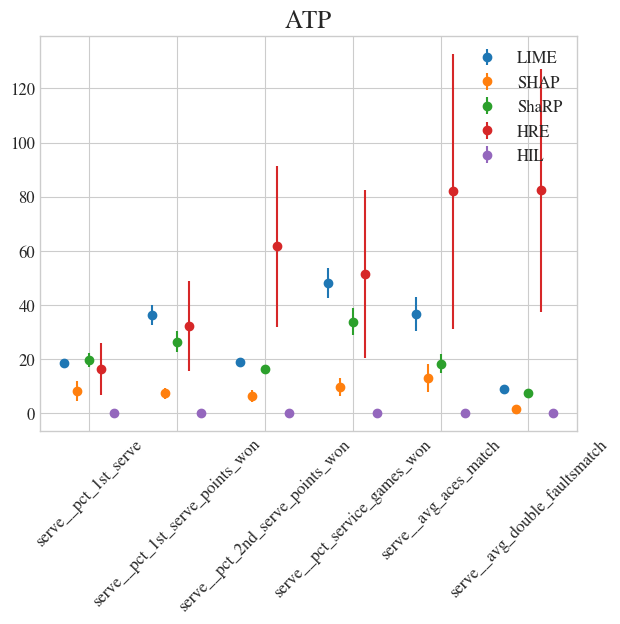

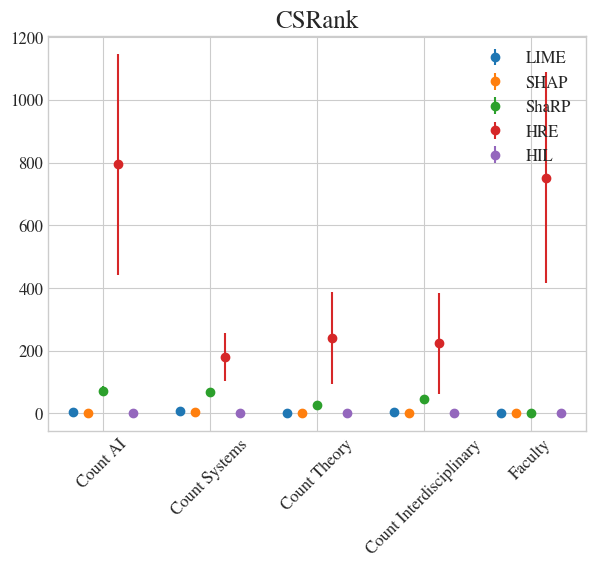

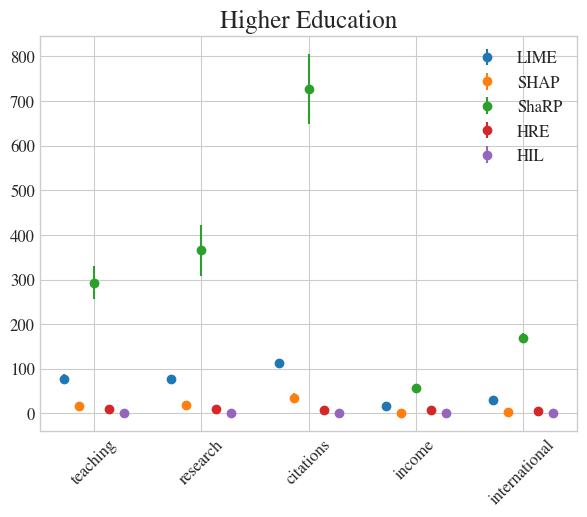

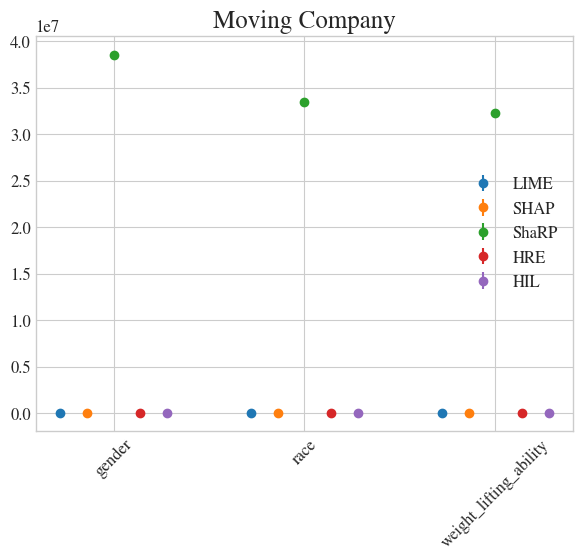

In [ ]:
set_matplotlib_style(font_size=12, **{"font.family": ["Nimbus Roman"]})
aggregated_summary, aggregated_error = compute_all_stability(results, axis=0)
for dataset in aggregated_summary:
    plot_dataset_aggregated_summary(
        aggregated_summary[dataset], aggregated_error[dataset]
    )
    plt.title(dataset)
    plt.show()

# Agreement

In [ ]:
agreement_results = compute_all_agreement(results, n_features=3)
agreement_results["ATP"]["kendall"]

Error in dataset: Moving Company, with methods: LIME, ShaRP
Error in dataset: Moving Company, with methods: LIME, HRE
Error in dataset: Moving Company, with methods: LIME, HIL
Error in dataset: Moving Company, with methods: SHAP, ShaRP
Error in dataset: Moving Company, with methods: SHAP, HRE
Error in dataset: Moving Company, with methods: SHAP, HIL
Error in dataset: Moving Company, with methods: ShaRP, LIME
Error in dataset: Moving Company, with methods: ShaRP, SHAP
Error in dataset: Moving Company, with methods: ShaRP, ShaRP
Error in dataset: Moving Company, with methods: ShaRP, HRE
Error in dataset: Moving Company, with methods: ShaRP, HIL
Error in dataset: Moving Company, with methods: HRE, LIME
Error in dataset: Moving Company, with methods: HRE, SHAP
Error in dataset: Moving Company, with methods: HRE, ShaRP
Error in dataset: Moving Company, with methods: HRE, HRE
Error in dataset: Moving Company, with methods: HRE, HIL
Error in dataset: Moving Company, with methods: HIL, LIME
Er

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.804651,0.790698,0.0,-0.062016
SHAP,0.804651,1.0,0.933333,0.003101,-0.071318
ShaRP,0.790698,0.933333,1.0,0.020155,-0.07907
HRE,0.0,0.003101,0.020155,1.0,0.156589
HIL,-0.062016,-0.071318,-0.07907,0.156589,1.0


In [ ]:
agreement_results["ATP"]["jaccard"]

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.886047,0.868605,0.359302,0.39186
SHAP,0.886047,1.0,0.947674,0.35814,0.402326
ShaRP,0.868605,0.947674,1.0,0.355814,0.398837
HRE,0.359302,0.35814,0.355814,1.0,0.390698
HIL,0.39186,0.402326,0.398837,0.390698,1.0


In [ ]:
agreement_results["CSRank"]["kendall"]

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.78836,0.685714,-0.065608,0.008466
SHAP,0.78836,1.0,0.649735,-0.154497,0.025397
ShaRP,0.685714,0.649735,1.0,0.128042,-0.085714
HRE,-0.065608,-0.154497,0.128042,1.0,-0.144974
HIL,0.008466,0.025397,-0.085714,-0.144974,1.0


In [ ]:
agreement_results["CSRank"]["jaccard"]

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.841799,0.806878,0.455026,0.426455
SHAP,0.841799,1.0,0.788889,0.436508,0.439153
ShaRP,0.806878,0.788889,1.0,0.569841,0.414286
HRE,0.455026,0.436508,0.569841,1.0,0.39418
HIL,0.426455,0.439153,0.414286,0.39418,1.0


In [ ]:
agreement_results["Higher Education"]["kendall"]

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.81446,0.797423,-0.147459,-0.044381
SHAP,0.81446,1.0,0.825483,-0.187545,0.012598
ShaRP,0.797423,0.825483,1.0,-0.04796,-0.114102
HRE,-0.147459,-0.187545,-0.04796,1.0,0.041947
HIL,-0.044381,0.012598,-0.114102,0.041947,1.0


# Sensitivity

In [ ]:
sensitivity_results = compute_all_sensitivity(
    original_data=datasets, 
    results=results, 
    n_neighbors=10
)

Error in dataset: Moving Company, with method: ShaRP
Error in dataset: Moving Company, with method: HRE
Error in dataset: Moving Company, with method: HIL


In [ ]:
pd.DataFrame(sensitivity_results[0])

,ATP,CSRank,Higher Education,Moving Company
HIL,0.260000,-0.040529,0.146127,NaN
HRE,0.353798,0.767937,0.712770,NaN
LIME,0.169767,0.536614,0.377409,0.556167
SHAP,0.130543,0.603280,0.358969,0.805500
ShaRP,0.167597,0.446984,0.326142,NaN


# Fidelity

In [ ]:
fidelity_results = compute_all_fidelity(
    original_data=datasets, 
    results=results, 
    random_state=RNG_SEED
)
pd.DataFrame(fidelity_results[0])

In [ ]:
pd.DataFrame(fidelity_results[0]).mean(1)# .drop(columns="Moving Company").mean(1)

LIME     24.708631
SHAP     75.238828
ShaRP     9.487175
HRE       6.296120
HIL      11.883854
dtype: float64